# Subgradient method

## Subgradient

- Analogue of gradient descent but for non-smooth function 
$$
x_{k+1} = x_k - \alpha_k g_k,
$$

where $g_k$ is a subgradient at $x_k$
- What is the main difference from the gradient descent?

### Step size selection

- Constant step size 
- Decreasing sequence $\alpha_k \to 0$ and $\sum_{k=1}^{\infty} \alpha_k = \infty$

### Convergence analysis

- $\|x_{k+1} - x^*\|^2_2 = \|x_k - \alpha_k g_k - x^*\|^2_2 \leq \|x_k - x^*\|^2_2 - 2\alpha_k g^{\top}_k(x_k - x^*) + \alpha^2_k \|g_k\|_2^2 \leq \|x_k - x^*\|_2 - 2\alpha_k (f(x_k) - f^*) + \alpha^2_k \|g\|_2^2$
- If we use the smallest objective function value after elapsed $k$ iterations $f_{best}^{(k)}$, we get the following inequality

$$
2 \left(\sum_{i=1}^k \alpha_i\right) (f^{(k)}_{best} - f^*) \leq \| x_0 - x^*\|_2^2 - \|x_k - x^* \|_2^2 + \sum_{i=1}^k \alpha^2_i \|g_i\|_2^2 \leq \| x_0 - x^*\|_2^2 + \sum_{i=1}^k \alpha^2_i \|g_i\|_2^2
$$


#### Constant step size 

$$
f^{(k)}_{best} - f^* \leq \frac{\| x_0 - x^*\|_2^2}{2k\alpha} + \frac{G^2 \alpha}{2}
$$

- What is $G$?
- Do we have convergence by objective function?

### Decreasing sequence

- $\alpha_i \to 0$ and $\sum_i^{\infty}\alpha_i = \infty$

$$
f^{(k)}_{best} - f^* \leq \frac{\| x_0 - x^*\|_2^2 + G^2 \sum_{i=1}^k \alpha_i^2}{2\sum_{i=1}^k \alpha_i}
$$

### Experiments

$$
\|Ax - b\|_1 \to \min_x
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss

m, n = 500, 100
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A.dot(x_true)

In [3]:
f = lambda x: np.linalg.norm(A.dot(x) - b, 1)
subgrad = lambda x: A.T.dot(np.sign(A.dot(x) - b))

sg_methods = {
    "SM 1 / k": methods.fo.SubgradientMethod(f, subgrad, ss.InvIterStepSize()),
    "SM fixed": methods.fo.SubgradientMethod(f, subgrad, ss.ConstantStepSize(1e-3)),
    "SM scaled fix": methods.fo.SubgradientMethod(f, subgrad, 
                                                  ss.ScaledConstantStepSize(1.)),
}

In [7]:
x0 = np.random.randn(n)
max_iter = 5000

In [8]:
for m in sg_methods:
    _ = sg_methods[m].solve(x0=x0, max_iter=max_iter)

Text(0, 0.5, 'Objective, $f(x_k)$')

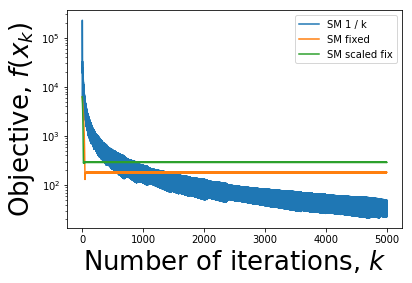

In [10]:
for m in sg_methods:
    plt.semilogy([f(x) for x in sg_methods[m].get_convergence()], label=m)
plt.legend()
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Objective, $f(x_k)$", fontsize=26)
# plt.xscale("log")

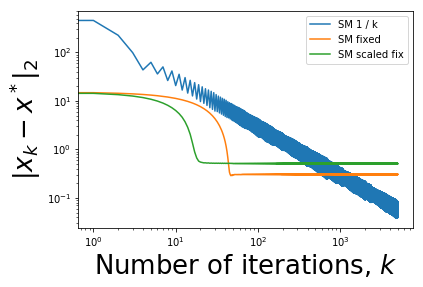

In [12]:
for m in sg_methods:
    plt.semilogy([np.linalg.norm(x_true - x) for x in sg_methods[m].get_convergence()], label=m)
plt.legend()
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"$\| x_k - x^*\|_2$", fontsize=26)
plt.xscale("log")

# Intro to acceleration methods

## Reminder about gradient descent

- Easy to implement
- It converges at least to stationary point
- Recent [paper](https://arxiv.org/pdf/1602.04915.pdf) shows that GD converges to a local minimizer **almost sure** with random initialization
- Linear convergence in strongly convex case
- $O(1/k)$ convergence in convex $L$-smooth case
- It strongly depends on the condition number of $f''(x)$, random initial guess vector can help

## Can we do better?

- Heavy-ball method
- Nesterov accelerated gradient method

## Heavy-ball method (Polyak, 1964)

$$
x_{k+1} = x_k - \alpha_k f'(x_k) + {\color{red}{\beta_k(x_k - x_{k-1})}}
$$

- Two-step non-monotone method
- Discretization of the ODE with friction term

$$
\ddot x + b \dot x + a f'(x) = 0
$$

- CG is special case of this form

### Heavy ball method visualization
Picture is from [this](https://www.princeton.edu/~yc5/ele538_optimization/lectures/accelerated_gradient.pdf) presentation
<img src="./heavy_ball.png" width=600 align="center">

### Convergence: $\mu$-strongly convex
- Rewrite method as 
\begin{equation*}
\begin{split} 
\begin{bmatrix} x_{k+1}\\ x_k \end{bmatrix}
 = \begin{bmatrix} (1 + \beta_k)I & -\beta_k I \\ I & 0 \end{bmatrix}
 \begin{bmatrix} x_k\\ x_{k-1} \end{bmatrix}
 +
 \begin{bmatrix} -\alpha_k f'(x_k)\\ 0 \end{bmatrix}
\end{split}
\end{equation*}
-  Use theorem from calculus
\begin{equation*}
\begin{split}
\begin{bmatrix} x_{k+1} - x^*\\ x_k - x^* \end{bmatrix}
 = 
 \underbrace{ \begin{bmatrix} (1 + \beta_k)I - \alpha_k \int_0^1 f''(x(\tau))d\tau & -\beta_k I\\ I & 0 \end{bmatrix}}_{=A_t}
 \begin{bmatrix} x_k - x^*\\ x_{k-1} - x^* \end{bmatrix},
\end{split}
\end{equation*}
where $x(\tau) = x_k + \tau(x^* - x_k) $
- Convergence depends on the spectrum of the iteration matrix $A_t$
- Select $\alpha_k$ and $\beta_k$ to make spectral radius the smallest 

### Theorem
Let $f$ be $L$-smooth and $\mu$-strongly convex. Then $\alpha_k = \frac{4}{(\sqrt{L} + \sqrt{\mu})^2}$ and $\beta_k = \max(|1 - \sqrt{\alpha_k L}|^2, |1 - \sqrt{\alpha_k \mu}|^2)$ gives

$$ 
\left\| \begin{bmatrix} x_{k+1} - x^* \\ x_k - x^* \end{bmatrix} \right\|_2
\leq 
\left( \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1} \right)^k \left \|
\begin{bmatrix} x_1 - x^* \\ x_0 - x^* \end{bmatrix}
\right \|_2
$$


- Parameters depend on $L$ and $\mu$
- Faster than GD
- Similar to CG for $\mu$-strongly convex quadratic
- Can such estimate be extend to $L$-smooth convex function?

In [13]:
import liboptpy.base_optimizer as base
import numpy as np
import liboptpy.unconstr_solvers.fo as fo
import liboptpy.step_size as ss

class HeavyBall(base.LineSearchOptimizer):
    def __init__(self, f, grad, step_size, beta, **kwargs):
        super().__init__(f, grad, step_size, **kwargs)
        self._beta = beta
    
    def get_direction(self, x):
        self._current_grad = self._grad(x)
        return -self._current_grad

    def _f_update_x_next(self, x, alpha, h):
        if len(self.convergence) < 2:
            return x + alpha * h
        else:
            return x + alpha * h + self._beta * (x - self.convergence[-2])
    
    def get_stepsize(self):
        return self._step_size.get_stepsize(self._grad_mem[-1], self.convergence[-1], len(self.convergence))

## Quadratic experiments

In [17]:
n = 50
A = np.random.randn(n, n)
A = A.T.dot(A)
x_true = np.random.randn(n)
b = A.dot(x_true)
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad = lambda x: A.dot(x) - b
A_eigvals = np.linalg.eigvalsh(A)
L = np.max(A_eigvals)
mu = np.min(A_eigvals)
print(L, mu, L / mu)
alpha_opt = 4 / (np.sqrt(L) + np.sqrt(mu))**2 
beta_opt = np.maximum((1 - np.sqrt(alpha_opt * L))**2, 
                      (1 - np.sqrt(alpha_opt * mu))**2)
print(alpha_opt, beta_opt)
# beta_opt = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))
# print((np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu)))

203.0960087188255 0.008079711589074084 25136.54187774044
0.01944900147902581 0.9750858581396608


In [39]:
methods = {
    "GD fixed": fo.GradientDescent(f, grad, ss.ConstantStepSize(1. / L)),
    "GD Armijo": fo.GradientDescent(f, grad, 
            ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
    "HB": HeavyBall(f, grad, ss.ConstantStepSize(1e-2), beta=0.9),
    "HB optimal": HeavyBall(f, grad, ss.ConstantStepSize(alpha_opt), beta = beta_opt)
}
x0 = np.random.randn(n)
max_iter = 25000
tol = 1e-6

In [40]:
for m in methods:
    _ = methods[m].solve(x0=x0, max_iter=max_iter, tol=tol)

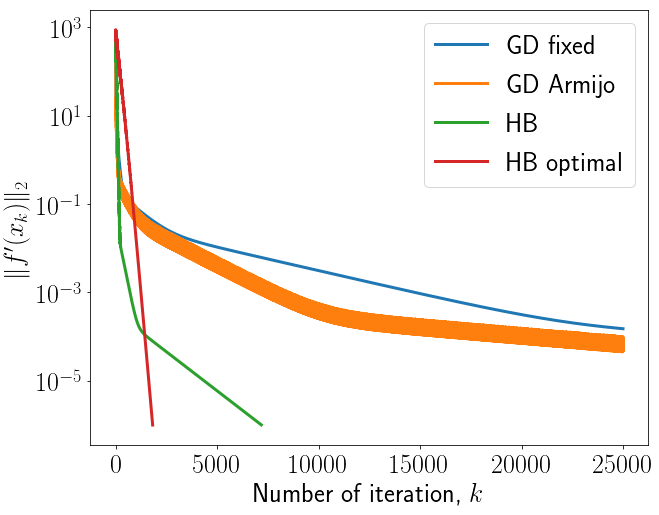

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)

figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)
for m in methods:
    plt.semilogy([np.linalg.norm(grad(x)) for x in methods[m].get_convergence()], label=m, linewidth=3)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

### Heavy-ball method highlights

- Simple two-step method
- Converges much faster than GD with appropriate $\alpha_k$, $\beta_k$
- CG is particular case
- Proof only for $\mu$-strongly convex functions

## Nesterov accelerated methods (Nesterov, 1983)

One of possible notation variant

\begin{equation*}
\begin{split}
& y_0 = x_0 \\
& x_{k+1} = y_k - \alpha_k f'(y_k)\\
& y_{k+1} = x_{k+1} + \frac{k}{k + 3} (x_{k+1} - x_k)
\end{split}
\end{equation*}

- Heavy-ball comparison
- ODE interpretation again
- Non-monotone, too
- For those who likes geometry there exists [geometric descent](https://arxiv.org/pdf/1506.08187.pdf) with the same optimal speed of convergence 

### Nesterov method visualization

<img src="nesterov_plot.png" width=600>

0.004923779675968134


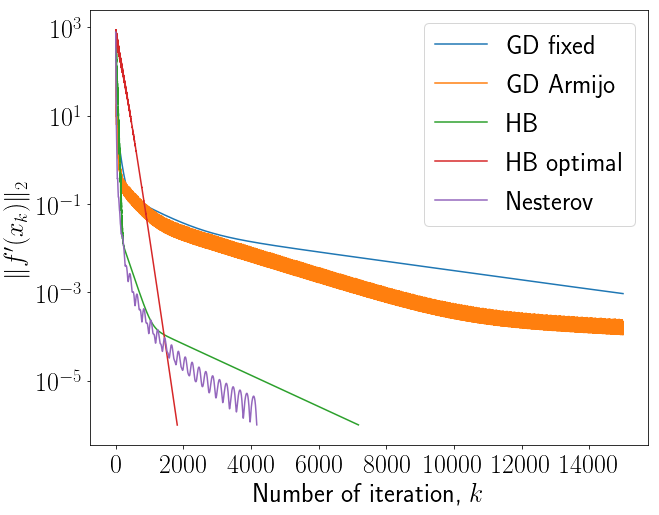

In [50]:
methods["Nesterov"] = fo.AcceleratedGD(f, grad, 
                                       ss.ConstantStepSize(1 / L))
methods["Nesterov"].solve(x0=x0, max_iter=max_iter, tol=tol)
plt.figure(figsize=figsize)
for m in methods:
    plt.semilogy([np.linalg.norm(grad(x)) for x in 
                  methods[m].get_convergence()[:15000]], label=m)
plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

## Nesterov accelerated method highlights

- Non-monotone, but [restarts](https://statweb.stanford.edu/~candes/papers/adap_restart_paper.pdf) can be useful
- Parameters tuning can be not so easy ($L$ and $\mu$ are unknown)
- Deep learning applications (see [Chapter 8 in Deep learning book](https://www.deeplearningbook.org/contents/optimization.html))
- Stochastic generalization